### Importing libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import yfinance as yf 

from sklearn.preprocessing import MinMaxScaler

### Getting the Stock Data

In [2]:
ticker = "NVDA"

start_training_date = datetime.date(2017, 10, 1)
end_training_date = datetime.date(2022, 7, 1)

start_testing_date = datetime.date(2022, 7, 2)
end_testing_date = datetime.date(2022,10,28)

In [3]:
df_training = yf.download(ticker, start=start_training_date, end=end_training_date, progress= False)
print(f"Downloaded {df_training.shape[0]} rows and {df_training.shape[1]} columns of {ticker} data")

df_testing = yf.download(ticker, start=start_testing_date - datetime.timedelta(days=60), end=end_testing_date, progress=False)
print(f"Downloaded {df_testing.shape[0]} rows and {df_testing.shape[1]} columns of {ticker} data")

Downloaded 1195 rows and 6 columns of NVDA data
Downloaded 124 rows and 6 columns of NVDA data


Text(0, 0.5, 'Prices ($)')

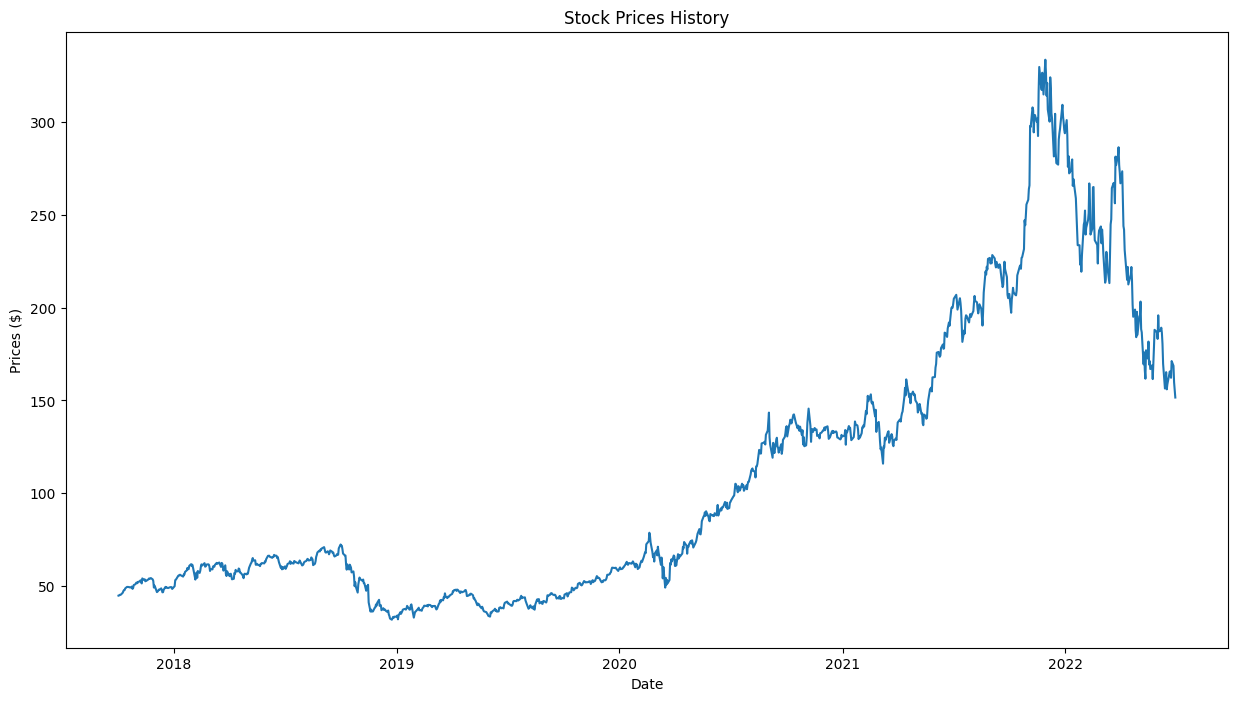

In [4]:
# Plotting the prices of the stock for training data
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(df_training['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [5]:
# Getting the close price for the training and testing datasets
trainset = df_training.iloc[:, 3:4].values

testset = df_testing.iloc[:, 3:4].values

print(f"Size of training set: {trainset.size}\nSize of testing set: {testset.size}")

Size of training set: 1195
Size of testing set: 124


### Data Normalization

In [6]:
# Creating a scaler to scale the values to a common scale for better performance
sc = MinMaxScaler(feature_range=(0,1))

trainset_scaled = sc.fit_transform(trainset)
testset_scaled = sc.fit_transform(testset)

### Incorporating Timesteps into Data

In [7]:
X_train = []
y_train = []

for i in range(60, trainset_scaled.size):
    X_train.append(trainset_scaled[i-60:i, 0])
    y_train.append(trainset_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [8]:
X_test = []
y_test = []

for i in range(60, testset_scaled.size):
    X_test.append(testset_scaled[i-60:i, 0])
    y_test.append(testset_scaled[i, 0])
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Creating the LSTM Model

In [9]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

In [10]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences=True, input_shape=(X_train.shape[1],1)))
# 20% of the layes will be dropped (avoid overfitting)
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [11]:
# Compiling the RNN
model.compile(optimizer='adam',loss='mean_squared_error')

# Fitting the RNN to the training set
final_model = model.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
36/36 [==============================] - 20s 95ms/step - loss: 0.0273
Epoch 2/100
36/36 [==============================] - 3s 83ms/step - loss: 0.0049
Epoch 3/100
36/36 [==============================] - 3s 79ms/step - loss: 0.0040
Epoch 4/100
36/36 [==============================] - 3s 74ms/step - loss: 0.0041
Epoch 5/100
36/36 [==============================] - 3s 90ms/step - loss: 0.0038
Epoch 6/100
36/36 [==============================] - 4s 99ms/step - loss: 0.0034
Epoch 7/100
36/36 [==============================] - 4s 104ms/step - loss: 0.0033
Epoch 8/100
36/36 [==============================] - 4s 106ms/step - loss: 0.0036
Epoch 9/100
36/36 [==============================] - 4s 107ms/step - loss: 0.0039
Epoch 10/100
36/36 [==============================] - 3s 84ms/step - loss: 0.0030
Epoch 11/100
36/36 [==============================] - 3s 78ms/step - loss: 0.0030
Epoch 12/100
36/36 [==============================] - 3s 70ms/step - loss: 0.0027
Epoch 13/100
36/36 [=

### Using the model to predict the stock prices

In [12]:
predicted_test_price = model.predict(X_test)
predicted_test_price = sc.inverse_transform(predicted_test_price)
real_test_price = sc.inverse_transform(y_test.reshape(-1,1))

2/2 [==============================] - 1s 20ms/step


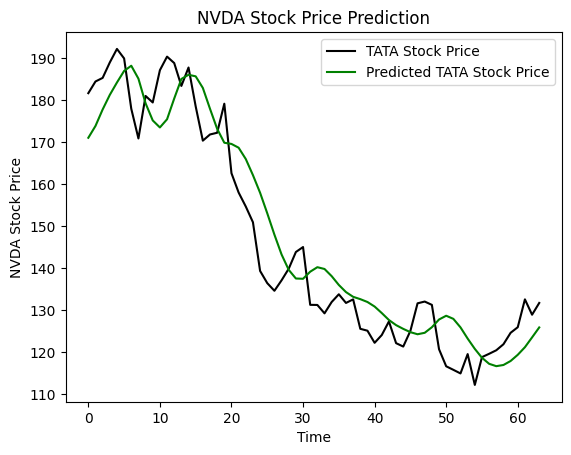

In [13]:
# Plotting the results
plt.plot(real_test_price, color = 'black', label = 'TATA Stock Price')
plt.plot(predicted_test_price, color = 'green', label = 'Predicted TATA Stock Price')
plt.title('NVDA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price')
plt.legend()
plt.show()

### Training on the full dataset

In [14]:
start = datetime.date(2017, 10, 1)
end = datetime.date(2022,10,28)

In [15]:
df = yf.download(ticker, start=start, end=end, progress=False)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker} data")

Downloaded 1278 rows and 6 columns of NVDA data


In [16]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-02,45.200001,45.494999,44.250000,44.750000,44.279072,50348000
2017-10-03,44.812500,45.145000,44.395000,44.842499,44.370594,39033200
2017-10-04,44.904999,45.442501,44.535000,45.217499,44.741653,42784800
2017-10-05,45.465000,45.500000,44.889999,45.192501,44.716911,43736400
2017-10-06,44.912498,45.459999,44.750000,45.325001,44.848026,31880000


<AxesSubplot:xlabel='Date'>

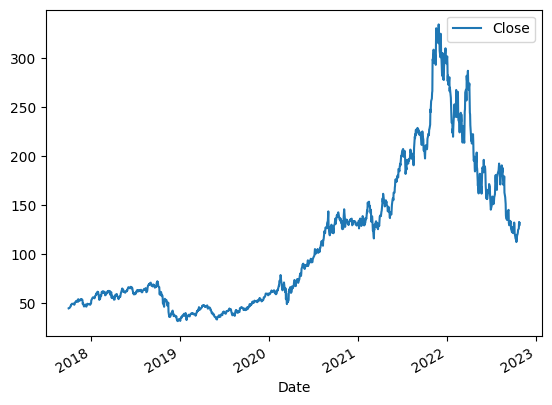

In [17]:
data = df.iloc[:, 3:4]
data[["Close"]].plot()

In [18]:
data_scaled = sc.fit_transform(data)

In [19]:
X1 = []
y1 = []
for i in range(60, int(data_scaled.size)):
    X1.append(data_scaled[i-60:i, 0])
    y1.append(data_scaled[i, 0])
X1, y1 = np.array(X1), np.array(y1)
X1 = np.reshape(X1, (X1.shape[0], X1.shape[1], 1))

In [20]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences=True, input_shape=(X_train.shape[1],1)))
# 20% of the layes will be dropped (avoid overfitting)
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

In [21]:
# Compiling the RNN
model.compile(optimizer='adam',loss='mean_squared_error')

# Fitting the RNN to the training set
final_model = model.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
36/36 [==============================] - 9s 68ms/step - loss: 0.0216
Epoch 2/100
36/36 [==============================] - 3s 71ms/step - loss: 0.0046
Epoch 3/100
36/36 [==============================] - 3s 74ms/step - loss: 0.0038
Epoch 4/100
36/36 [==============================] - 3s 72ms/step - loss: 0.0038
Epoch 5/100
36/36 [==============================] - 3s 73ms/step - loss: 0.0034
Epoch 6/100
36/36 [==============================] - 3s 72ms/step - loss: 0.0033
Epoch 7/100
36/36 [==============================] - 3s 71ms/step - loss: 0.0033
Epoch 8/100
36/36 [==============================] - 2s 69ms/step - loss: 0.0034
Epoch 9/100
36/36 [==============================] - 3s 72ms/step - loss: 0.0030
Epoch 10/100
36/36 [==============================] - 3s 72ms/step - loss: 0.0034
Epoch 11/100
36/36 [==============================] - 3s 77ms/step - loss: 0.0032
Epoch 12/100
36/36 [==============================] - 4s 113ms/step - loss: 0.0027
Epoch 13/100
36/36 [====

In [ ]:
start_predict_date = datetime.date(2022, 10, 29)
end_predict_date = datetime.date(2022, 11, 12)

In [ ]:
next_14_days = []

for i in range(14):

    current_date = datetime.date(2022,10,29) + datetime.timedelta(days=i)

    test_x = []
    test_x.append(data_scaled[len(data_scaled)-60:, 0])
    test_x = np.array(test_x)
    test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1],1))

    prediction = model.predict(test_x)
    data_scaled = np.append(data_scaled, prediction)

    prediction = sc.inverse_transform(prediction)
    print(prediction)
    next_14_days = next_14_days + prediction.flatten().tolist()

    data_scaled = np.reshape(data_scaled, (data_scaled.size,1))



1/1 [==============================] - 1s 1s/step
[[129.85873]]
1/1 [==============================] - 0s 27ms/step
[[130.91101]]
1/1 [==============================] - 0s 25ms/step
[[131.3556]]
1/1 [==============================] - 0s 25ms/step
[[131.48938]]
1/1 [==============================] - 0s 29ms/step
[[131.51012]]
1/1 [==============================] - 0s 27ms/step
[[131.5057]]
1/1 [==============================] - 0s 29ms/step
[[131.5023]]
1/1 [==============================] - 0s 26ms/step
[[131.5037]]
1/1 [==============================] - 0s 26ms/step
[[131.50961]]
1/1 [==============================] - 0s 29ms/step
[[131.52069]]
1/1 [==============================] - 0s 28ms/step
[[131.53842]]
1/1 [==============================] - 0s 26ms/step
[[131.56422]]
1/1 [==============================] - 0s 25ms/step
[[131.59894]]
1/1 [==============================] - 0s 25ms/step
[[131.64276]]


In [ ]:
answer = pd.DataFrame(
            data = next_14_days,
            columns=["Close"]
            )

In [ ]:
answer.to_csv('model1.csv')

### Things to improve on:

1) Seeing if LSTM can take in other parameters like macroeconomics indicators